In [31]:
import hopsworks
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import os

In [32]:
import hsfs

# 1. Login
project = hopsworks.login()

# 2. Get the Feature Store (This triggers the metadata check)
try:
    fs = project.get_feature_store("A1ID2223")
    print(f"Successfully connected to Feature Store: {fs.name}")
except Exception as e:
    print(f"Feature Store Connection Error: {e}")

# 3. Check versions
print(f"HSFS Version: {hsfs.__version__}")

2025-12-28 17:26:08,281 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-12-28 17:26:08,285 INFO: Initializing external client
2025-12-28 17:26:08,285 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-12-28 17:26:09,989 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1267871
Successfully connected to Feature Store: a1id2223_featurestore
HSFS Version: 4.2.10


In [33]:
sentiments = fs.get_feature_group(name="sentiments")
opening = fs.get_feature_group(name="opening_prices", version=2)


2025-12-28 17:26:11,398 WARNING: VersionWarning: No version provided for getting feature group `sentiments`, defaulting to `1`.



In [34]:
sentiments = sentiments.read()
opening = opening.read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.33s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.88s) 


In [35]:
sentiments['date'].max()

Timestamp('2025-12-28 00:00:00+0000', tz='Etc/UTC')

In [36]:
opening['date'].max()

Timestamp('2025-12-26 00:00:00+0000', tz='Etc/UTC')

In [37]:
# Merge sentiment and opening price data
merged = sentiments.merge(opening, on='date', how='inner')  # Inner join drops weekends

In [38]:
# Filter to only dates where we have both sentiment and opening prices
merged = sentiments.merge(opening, on='date', how='inner', suffixes=('_sent', '_open'))
print(f"After filtering: {len(merged)} dates with both sentiment and opening prices")

After filtering: 1132 dates with both sentiment and opening prices


In [39]:
merged['date'].max()

Timestamp('2025-12-23 00:00:00+0000', tz='Etc/UTC')

## Prepare Data for Inference
Remove rows with missing target_open (like today's date) and prepare features for prediction.

In [40]:
# Sort by date to see the data range
merged_sorted = merged.sort_values('date')
print(f"Date range: {merged_sorted['date'].min()} to {merged_sorted['date'].max()}")
print(f"\nFirst few rows:")
print(merged_sorted.head())
print(f"\nLast few rows:")
print(merged_sorted.tail())

Date range: 2016-02-19 00:00:00+00:00 to 2025-12-23 00:00:00+00:00

First few rows:
                          date  sentiment_polarity  sentiment_neg  \
1103 2016-02-19 00:00:00+00:00               0.994          0.023   
490  2017-10-05 00:00:00+00:00               0.997          0.008   
225  2017-11-27 00:00:00+00:00               0.997          0.008   
169  2017-11-30 00:00:00+00:00               0.989          0.021   
274  2018-01-31 00:00:00+00:00               0.995          0.009   

      sentiment_neu  sentiment_pos       open  target_open  
1103          0.869          0.108  21.762474    21.832745  
490           0.925          0.067  35.978361    36.162712  
225           0.926          0.065  40.995288    40.819637  
169           0.804          0.174  39.913309    39.800916  
274           0.937          0.054  39.079596    39.149848  

Last few rows:
                          date  sentiment_polarity  sentiment_neg  \
635  2024-11-19 00:00:00+00:00            0.527000

In [41]:
# Filter out rows with null target_open (typically today's date)
inference_data = merged[merged['target_open'].notna()].copy()
print(f"Filtered data: {len(inference_data)} rows with valid target_open")
print(f"\nNull target_open count: {merged['target_open'].isna().sum()}")

Filtered data: 1131 rows with valid target_open

Null target_open count: 1


In [46]:
# Prepare features (X) and target (y) for inference
# Features: sentiment columns and open price
# Note: Model was trained with 'opening_prices_open' not 'open', so we need to rename
feature_cols = ['sentiment_polarity', 'sentiment_neg', 'sentiment_neu', 'sentiment_pos', 'opening_prices_open']

# Rename the open column to match training feature names
inference_data = inference_data.rename(columns={'open': 'opening_prices_open'})

X_inference = inference_data[feature_cols]
y_actual = inference_data['target_open']

print(f"Features shape: {X_inference.shape}")
print(f"Features: {feature_cols}")
print(f"\nColumn names in inference_data: {inference_data.columns.tolist()}")

Features shape: (1131, 5)
Features: ['sentiment_polarity', 'sentiment_neg', 'sentiment_neu', 'sentiment_pos', 'opening_prices_open']

Column names in inference_data: ['date', 'sentiment_polarity', 'sentiment_neg', 'sentiment_neu', 'sentiment_pos', 'opening_prices_open', 'target_open']


## Load Model from Hopsworks Model Registry

In [47]:
import xgboost

# Get model registry
mr = project.get_model_registry()

# Retrieve the model
model_name = "sentiment_stock_price_model_AAPL"
model = mr.get_model(model_name, version=1)

# Download model artifacts to local directory
model_dir = model.download()
print(f"Model downloaded to: {model_dir}")

Downloading: 0.000%|          | 0/441617 elapsed<00:00 remaining<?

Model downloaded to: /var/folders/2x/6wpkl49n4bsfkkvhr3gm3tt00000gn/T/111653c1-804a-44c4-9ac5-d350658e51d3/sentiment_stock_price_model_AAPL/1


In [48]:
# Load the XGBoost model
model_path = os.path.join(model_dir, "model.json")
xgb_model = xgboost.XGBRegressor()
xgb_model.load_model(model_path)
print(f"Model loaded from {model_path}")

Model loaded from /var/folders/2x/6wpkl49n4bsfkkvhr3gm3tt00000gn/T/111653c1-804a-44c4-9ac5-d350658e51d3/sentiment_stock_price_model_AAPL/1/model.json


## Make Predictions

In [49]:
# Make predictions
y_pred = xgb_model.predict(X_inference)

# Create a results dataframe (use the renamed column)
results = inference_data[['date', 'opening_prices_open', 'target_open']].copy()
results['predicted_open'] = y_pred

# Rename back for display clarity
results = results.rename(columns={'opening_prices_open': 'open'})

print(f"Predictions made for {len(results)} dates")
print("\nLast 10 predictions:")
print(results.tail(10))

Predictions made for 1131 dates

Last 10 predictions:
                          date        open  target_open  predicted_open
1121 2024-03-25 00:00:00+00:00  169.189827   168.624454      171.580170
1122 2024-07-16 00:00:00+00:00  233.414649   227.902100      191.573898
1123 2022-02-22 00:00:00+00:00  161.796055   162.345304      162.538651
1124 2023-12-12 00:00:00+00:00  191.273627   193.264827      193.196854
1125 2021-05-26 00:00:00+00:00  123.984429   123.476620      124.152138
1126 2024-07-22 00:00:00+00:00  225.478570   222.856384      193.386536
1127 2024-04-18 00:00:00+00:00  166.670364   164.865133      165.324951
1128 2021-05-24 00:00:00+00:00  123.056674   124.824271      124.261086
1129 2021-09-27 00:00:00+00:00  142.273452   140.102238      140.348755
1130 2023-02-06 00:00:00+00:00  150.302518   148.401180      148.503006


## Evaluate Performance

In [50]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Calculate metrics
mse = mean_squared_error(y_actual, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_actual, y_pred)
r2 = r2_score(y_actual, y_pred)

print("=" * 50)
print("INFERENCE PERFORMANCE METRICS")
print("=" * 50)
print(f"Mean Squared Error (MSE):  {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print("=" * 50)

2025-12-28 17:27:48,000 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2025-12-28 17:27:48,000 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2025-12-28 17:27:48,001 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2025-12-28 17:27:48,002 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2025-12-28 17:27:48,002 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2025-12-28 17:27:48,003 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.Spar

## Visualize Results

2025-12-28 17:27:50,667 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



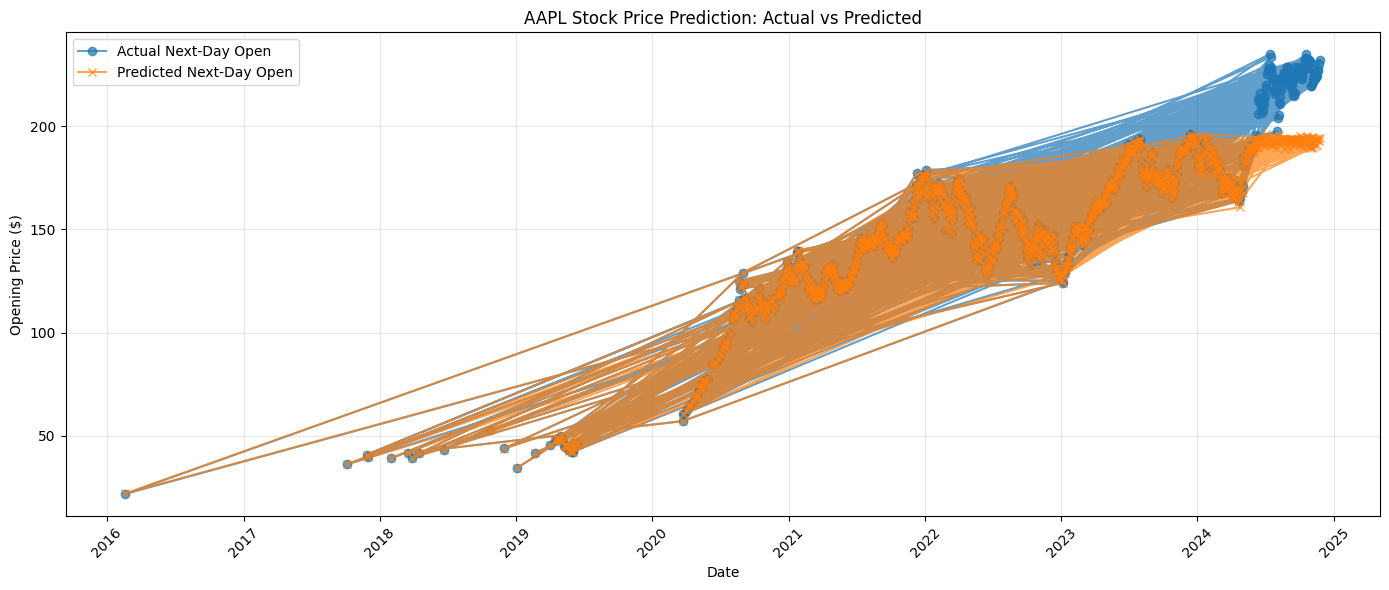

In [51]:
# Plot actual vs predicted prices over time
plt.figure(figsize=(14, 6))
plt.plot(results['date'], results['target_open'], label='Actual Next-Day Open', marker='o', alpha=0.7)
plt.plot(results['date'], results['predicted_open'], label='Predicted Next-Day Open', marker='x', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Opening Price ($)')
plt.title('AAPL Stock Price Prediction: Actual vs Predicted')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

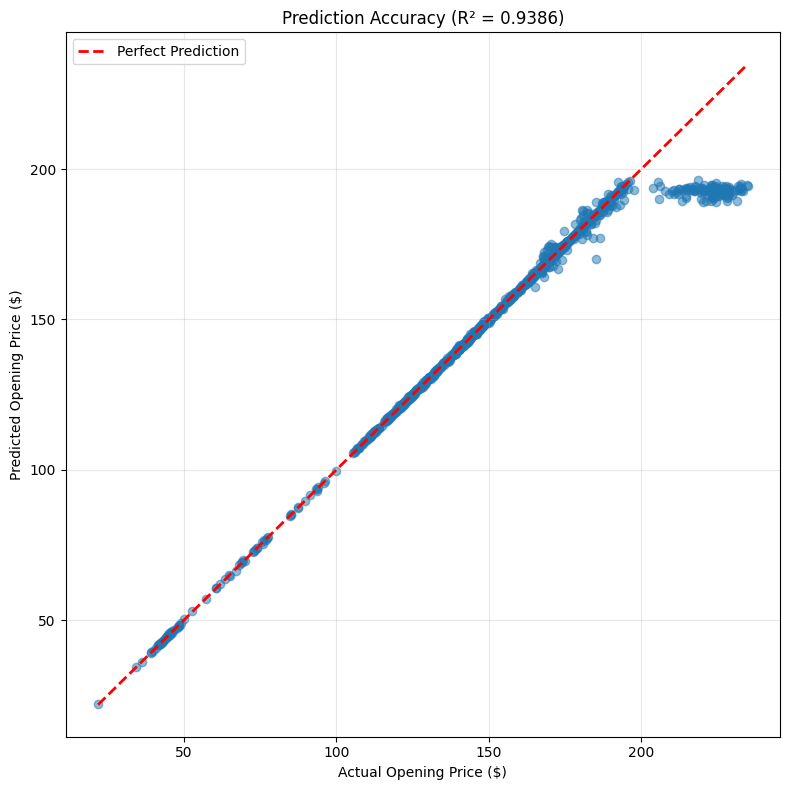

In [52]:
# Scatter plot: Predicted vs Actual
plt.figure(figsize=(8, 8))
plt.scatter(y_actual, y_pred, alpha=0.5)
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Opening Price ($)')
plt.ylabel('Predicted Opening Price ($)')
plt.title(f'Prediction Accuracy (R² = {r2:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [53]:
# Calculate prediction errors
results['error'] = results['predicted_open'] - results['target_open']
results['abs_error'] = np.abs(results['error'])
results['pct_error'] = (results['error'] / results['target_open']) * 100

# Show error statistics
print("Error Statistics:")
print(f"Mean Error: ${results['error'].mean():.2f}")
print(f"Mean Absolute Error: ${results['abs_error'].mean():.2f}")
print(f"Mean Percentage Error: {results['pct_error'].mean():.2f}%")
print(f"Std Dev of Error: ${results['error'].std():.2f}")
print(f"\nBest 5 Predictions (smallest absolute error):")
print(results.nsmallest(5, 'abs_error')[['date', 'target_open', 'predicted_open', 'abs_error']])
print(f"\nWorst 5 Predictions (largest absolute error):")
print(results.nlargest(5, 'abs_error')[['date', 'target_open', 'predicted_open', 'abs_error']])

Error Statistics:
Mean Error: $-3.03
Mean Absolute Error: $3.42
Mean Percentage Error: -1.35%
Std Dev of Error: $9.32

Best 5 Predictions (smallest absolute error):
                          date  target_open  predicted_open  abs_error
1041 2023-11-22 00:00:00+00:00   189.084308      189.084335   0.000028
699  2022-02-14 00:00:00+00:00   167.670515      167.670761   0.000247
500  2023-08-02 00:00:00+00:00   189.272501      189.271683   0.000818
141  2020-08-31 00:00:00+00:00   129.012918      129.011749   0.001169
828  2022-03-09 00:00:00+00:00   157.108356      157.107132   0.001224

Worst 5 Predictions (largest absolute error):
                          date  target_open  predicted_open  abs_error
1047 2024-10-29 00:00:00+00:00   231.308219      189.292435  42.015784
185  2024-07-15 00:00:00+00:00   233.414649      192.731766  40.682883
56   2024-07-12 00:00:00+00:00   234.884665      194.286835  40.597830
982  2024-10-17 00:00:00+00:00   234.858234      194.588287  40.269947
330  20

## Recent Predictions (Including Unvalidated)
Show predictions for the most recent dates, including today's prediction for tomorrow (which can't be validated yet).

In [54]:
# Check if there are rows with null target_open (recent dates we can predict but not validate)
unvalidated_data = merged[merged['target_open'].isna()].copy()

if len(unvalidated_data) > 0:
    print(f"Found {len(unvalidated_data)} recent dates without validation data (target_open is null)")
    print(f"These are dates: {unvalidated_data['date'].tolist()}")
    
    # Rename column to match model expectations
    unvalidated_data = unvalidated_data.rename(columns={'open': 'opening_prices_open'})
    
    # Make predictions for these dates
    X_recent = unvalidated_data[feature_cols]
    y_pred_recent = xgb_model.predict(X_recent)
    
    # Create results dataframe
    recent_results = unvalidated_data[['date', 'opening_prices_open']].copy()
    recent_results['predicted_next_day_open'] = y_pred_recent
    recent_results = recent_results.rename(columns={'opening_prices_open': 'current_open'})
    
    print("\n" + "=" * 60)
    print("PREDICTIONS FOR RECENT DATES (Not Yet Validated)")
    print("=" * 60)
    print(recent_results.to_string(index=False))
    print("=" * 60)
    print("\nNote: These predictions are for the next trading day's opening price.")
    print("They cannot be validated yet because that trading day hasn't occurred.")
else:
    print("No recent unvalidated dates found. All data has known target_open values.")

Found 1 recent dates without validation data (target_open is null)
These are dates: [Timestamp('2025-12-23 00:00:00+0000', tz='Etc/UTC')]

PREDICTIONS FOR RECENT DATES (Not Yet Validated)
                     date  current_open  predicted_next_day_open
2025-12-23 00:00:00+00:00    270.839996               190.853241

Note: These predictions are for the next trading day's opening price.
They cannot be validated yet because that trading day hasn't occurred.


In [55]:
# Show a complete timeline: validated predictions + recent unvalidated predictions
print("\nComplete Prediction Timeline:")
print(f"Validated predictions (with actual outcomes): {len(results)} dates")
print(f"  Date range: {results['date'].min()} to {results['date'].max()}")

if len(unvalidated_data) > 0:
    print(f"\nUnvalidated predictions (future): {len(recent_results)} dates")
    print(f"  Date range: {recent_results['date'].min()} to {recent_results['date'].max()}")
    print(f"\n  Latest prediction: On {recent_results['date'].max().date()}, ")
    print(f"  predict next trading day open = ${recent_results['predicted_next_day_open'].iloc[-1]:.2f}")


Complete Prediction Timeline:
Validated predictions (with actual outcomes): 1131 dates
  Date range: 2016-02-19 00:00:00+00:00 to 2024-11-25 00:00:00+00:00

Unvalidated predictions (future): 1 dates
  Date range: 2025-12-23 00:00:00+00:00 to 2025-12-23 00:00:00+00:00

  Latest prediction: On 2025-12-23, 
  predict next trading day open = $190.85
